In [80]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pyro.infer import Predictive
import time
import matplotlib.pyplot as plt

In [81]:
# # # Cancer
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     # Load the dataset
#     df = pd.read_csv(file_path)
#     print("Loaded dataset with shape:", df.shape)

#     # Define target and feature columns correctly
#     target_col = "diagnosis"
#     feature_cols = df.columns[2:]  # Exclude 'id' (first column) and take features from column 3 onward

#     # Extract features (X) and target labels (y)
#     X = df[feature_cols].values
#     y = df[target_col].values

#     # Encode 'diagnosis' column ('M' -> 1, 'B' -> 0)
#     le = LabelEncoder()
#     y = le.fit_transform(y)  # Converts "M"/"B" to 1/0

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Check for NaNs and replace if necessary
#     if np.isnan(X_scaled).any():
#         print("⚠️ Warning: NaNs found in dataset! Replacing with zeros.")
#         X_scaled = np.nan_to_num(X_scaled)

#     # Print class distribution
#     unique, counts = np.unique(y, return_counts=True)
#     print("Class Distribution:", dict(zip(unique, counts)))

#     # Ensure valid test size
#     min_class_samples = min(counts)
#     test_size = min(0.3, max(0.1, (min_class_samples - 1) / len(y)))

#     # Perform train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_scaled, y, test_size=test_size, random_state=random_state, stratify=y if min_class_samples > 1 else None
#     )
#     # Convert to PyTorch tensors **before checking for NaNs**
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

#     X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
#     y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

#     # Now it's safe to check for NaNs
#     print("NaNs in X_train:", torch.isnan(X_train_tensor).sum().item())
#     print("NaNs in y_train:", torch.isnan(y_train_tensor).sum().item())


#     input_dim = X_train_tensor.shape[1]
#     output_dim = 1  # Binary classification, should be 1 for Pyro's Bernoulli

#     return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, output_dim

In [82]:
def prepare_tensors(X, y, test_size=0.3, random_state=42):
    """Converts NumPy arrays into PyTorch tensors and performs train-test split."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if len(set(y)) > 1 else None
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # 🔹 Change to `torch.float32`
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)  # 🔹 Change to `torch.float32`

    input_dim = X_train_tensor.shape[1]
    output_dim = 1  # 🔹 Should be 1 for binary classification with BCE loss

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, output_dim

In [83]:
# # hepatitis
# # # 🚀 Function 1: Load and Preprocess Data
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path, na_values="?")
#     print("Loaded Hepatitis dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "out_class"
#     feature_cols = df.columns[1:]

#     # Convert target labels (2 → 1 "Survived", 1 → 0 "Died")
#     df["out_class"] = df["out_class"].replace({2: 1, 1: 0})

#     # Convert binary categorical features (1 → 0 "No", 2 → 1 "Yes")
#     binary_cols = ["sex", "steroid", "antivirals", "fatigue", "malaise", "anorexia",
#                    "liver_big", "liver_firm", "spleen_palable", "spiders", "ascites",
#                    "varices", "histology"]
#     df[binary_cols] = df[binary_cols].replace({1: 0, 2: 1})

#     # Fill missing values with column means
#     df.fillna(df.mean(), inplace=True)

#     # Standardize numerical features
#     numerical_cols = ["age", "bilirubin", "alk_phosphate", "sgot", "albumin", "protime"]
#     scaler = StandardScaler()
#     df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#     # Extract features and target
#     X = df[feature_cols].values
#     y = df["out_class"].values

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)


In [84]:
# # # heart_statlog_cleveland_hungary_final
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path)
#     print("Loaded Heart (Statlog + Cleveland + Hungary) dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "target"
#     feature_cols = df.columns[:-1]  # All except target

#     # Convert multiclass labels (1, 2, 3, 4) → Binary classification (1: Disease, 0: No Disease)
#     df[target_col] = df[target_col].apply(lambda x: 1 if x > 0 else 0)

#     # Standardize features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(df[feature_cols].values)

#     y = df[target_col].values

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)

In [85]:
# # heart
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path)
#     print("Loaded Heart dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "target"
#     feature_cols = df.columns[:-1]  # All columns except target

#     # Extract features and target
#     X = df[feature_cols].values
#     y = df[target_col].values

#     # Standardize numerical features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)


In [86]:
#  # diabetis
def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
    df = pd.read_csv(file_path)
    print("Loaded Diabetes dataset with shape:", df.shape)

    # Define target and feature columns
    target_col = "Outcome"
    feature_cols = df.columns[:-1]  # All except target

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols].values)

    y = df[target_col].values

    # Train-test split
    return prepare_tensors(X, y, test_size, random_state)


In [87]:
class BayesianFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=3):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def model(self, X, y=None):
        batch_size = X.shape[0]

        # Define priors
        w1 = pyro.sample("w1", dist.Normal(torch.zeros(self.input_dim, self.hidden_dim),
                                           torch.ones(self.input_dim, self.hidden_dim)).to_event(2))
        b1 = pyro.sample("b1", dist.Normal(torch.zeros(self.hidden_dim),
                                           torch.ones(self.hidden_dim)).to_event(1))

        w2 = pyro.sample("w2", dist.Normal(torch.zeros(self.hidden_dim, 1),
                                           torch.ones(self.hidden_dim, 1)).to_event(2))
        b2 = pyro.sample("b2", dist.Normal(torch.tensor(0.0),
                                           torch.tensor(1.0)))

        # Forward pass
        hidden = torch.relu(torch.matmul(X, w1) + b1)
        logits = torch.matmul(hidden, w2) + b2
        probs = torch.sigmoid(logits).squeeze(-1)  # Ensure shape is `[batch_size]`

        # ★ CHANGED: Return predictions when y is None ★
        if y is not None:
            with pyro.plate("data", batch_size):
                pyro.sample("obs", dist.Bernoulli(probs), obs=y)
        else:
            # ★ CHANGED: Use "prediction" instead of "obs" for prediction
            prediction = pyro.sample("prediction", dist.Bernoulli(probs))
            return prediction

    def guide(self, X, y=None):
        # Define variational parameters
        w1_loc = pyro.param("w1_loc", torch.zeros(self.input_dim, self.hidden_dim))
        w1_scale = pyro.param("w1_scale", torch.ones(self.input_dim, self.hidden_dim), constraint=dist.constraints.positive)

        b1_loc = pyro.param("b1_loc", torch.zeros(self.hidden_dim))
        b1_scale = pyro.param("b1_scale", torch.ones(self.hidden_dim), constraint=dist.constraints.positive)

        w2_loc = pyro.param("w2_loc", torch.zeros(self.hidden_dim, 1))
        w2_scale = pyro.param("w2_scale", torch.ones(self.hidden_dim, 1), constraint=dist.constraints.positive)

        b2_loc = pyro.param("b2_loc", torch.tensor(0.0))
        b2_scale = pyro.param("b2_scale", torch.tensor(1.0), constraint=dist.constraints.positive)

        # Sample from variational distributions
        pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
        pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))
        pyro.sample("w2", dist.Normal(w2_loc, w2_scale).to_event(2))
        pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

    # 🔹 Fix: Implement `forward()` to avoid `NotImplementedError`
    def forward(self, X):
        return self.model(X, y=None)
    
    def predict(self, X, num_samples=100):
        """
        Uses pyro.infer.Predictive to generate multiple samples from the posterior predictive distribution.
        Returns a tensor of shape [num_samples, batch_size] containing binary predictions.
        """
        self.eval()
        # ★ CHANGED: Pass the guide as a keyword argument and use the "prediction" key
        predictive = Predictive(self.model, guide=self.guide, num_samples=num_samples)
        samples = predictive(X)
        return samples["prediction"]




In [88]:
# 🚀 Function 2: Train Model
def train_model(X_train, y_train, input_dim, num_epochs=1000):
    pyro.clear_param_store()  # 🔹 Reset Pyro parameters
    model = BayesianFNN(input_dim)  # 🔹 Instantiate the BayesianFNN model

    # Set up inference algorithm
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO(num_particles=1))  # 🔹 Pass `model.guide`

    # Training Loop
    for epoch in range(num_epochs):
        loss = svi.step(X_train, y_train)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")

    # Extract Trained Parameters
    trained_params = {
        "w1_loc": pyro.param("w1_loc").detach().numpy(),
        "w1_scale": pyro.param("w1_scale").detach().numpy(),
        "b1_loc": pyro.param("b1_loc").detach().numpy(),
        "b1_scale": pyro.param("b1_scale").detach().numpy(),
        "w2_loc": pyro.param("w2_loc").detach().numpy(),
        "w2_scale": pyro.param("w2_scale").detach().numpy(),
        "b2_loc": pyro.param("b2_loc").item(),
        "b2_scale": pyro.param("b2_scale").item()
    }

    print("\nTrained Variational Parameters:")
    print(trained_params)
    return model  # 🔹 Return trained model


In [89]:


def evaluate_model(model, X_test, y_test):
    # ★ CHANGED: Remove Predictive and directly use the model's forward pass for prediction.
    model.eval()
    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # Directly obtain predicted probabilities from the model
    pred_probs = model(x_test_tensor).detach().numpy()  # Forward pass now returns probabilities directly
    
    # ★ CHANGED: For binary classification, threshold at 0.5 to get predicted labels.
    predictions = (pred_probs > 0.5).astype(int)
    
    # Ensure y_test is a numpy array for comparison
    accuracy = np.mean(predictions == y_test.numpy().flatten())
    print(f"Model Accuracy: {accuracy * 100:.2f}%")





In [90]:
def compute_nll_from_data(model, x_test, y_test, device='cpu'):
    model.eval()
    # Convert x_test to tensor if needed
    if not isinstance(x_test, torch.Tensor):
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    else:
        x_test_tensor = x_test.to(device)
    
    # Convert y_test to tensor if needed
    if not isinstance(y_test, torch.Tensor):
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    else:
        y_test_tensor = y_test.to(device)
    
    with torch.no_grad():
        # ★ CHANGED: Use the model to get probabilities directly
        probs = model(x_test_tensor)
        # ★ CHANGED: Remove F.log_softmax and instead clamp probabilities to avoid log(0)
        eps = 1e-8
        probs = torch.clamp(probs, eps, 1 - eps)
        # ★ CHANGED: Compute binary NLL using binary cross-entropy formulation
        nll = - (y_test_tensor * torch.log(probs) + (1 - y_test_tensor) * torch.log(1 - probs)).mean()
    return nll.item()


def compute_ece_from_data(model, x_test, y_test, num_bins=15, device='cpu'):
    model.eval()
    if not isinstance(x_test, torch.Tensor):
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    else:
        x_test_tensor = x_test.to(device)
    
    if not isinstance(y_test, torch.Tensor):
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    else:
        y_test_tensor = y_test.to(device)
    
    with torch.no_grad():
        outputs = model(x_test_tensor)
        # ★ CHANGED: Remove softmax since outputs are already probabilities
        confidences = outputs  # Use the model output directly as the confidence
        # ★ CHANGED: For binary classification, predicted labels are obtained by thresholding at 0.5
        predictions = (confidences >= 0.5).long()
    
    # Create bins and compute ECE
    bin_boundaries = torch.linspace(0, 1, num_bins + 1)
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        if in_bin.sum() > 0:
            avg_confidence = confidences[in_bin].mean().item()
            accuracy = (predictions[in_bin] == y_test_tensor[in_bin]).float().mean().item()
            bin_prob = in_bin.float().mean().item()  # fraction of samples in this bin
            ece += abs(avg_confidence - accuracy) * bin_prob
    return ece


In [91]:
# 🚀 Function 4: Main
def main():
    # file_path = "hepatitis.csv"  # Replace with actual file path
    file_path = "DataSets/diabetes.csv" 
    X_train, X_test, y_train, y_test, input_dim, _ = load_and_preprocess_data(file_path)
    start_train = time.time()
    model = train_model(X_train, y_train, input_dim)
    end_train = time.time()
    train_time = end_train - start_train
    print("Training time for VI NN: {:.4f} seconds".format(train_time))

    start_train = time.time()
    evaluate_model(model, X_test, y_test)
    end_train = time.time()
    train_time = end_train - start_train
    print("Inference time for Freqtist NN: {:.4f} seconds".format(train_time))

    return model, X_test, y_test
    

Loaded Diabetes dataset with shape: (768, 9)
Epoch 0: Loss = 420.63275146484375
Epoch 100: Loss = 352.2545716762543
Epoch 200: Loss = 434.08841997385025
Epoch 300: Loss = 342.5439165830612
Epoch 400: Loss = 367.84368282556534
Epoch 500: Loss = 341.62158554792404
Epoch 600: Loss = 384.2946621775627
Epoch 700: Loss = 310.09318047761917
Epoch 800: Loss = 331.9797782897949
Epoch 900: Loss = 316.574336707592

Trained Variational Parameters:
{'w1_loc': array([[-0.43336782, -0.8982685 , -0.38624334],
       [-1.1457318 , -1.5884626 , -0.95627517],
       [ 0.34984592,  0.38831457,  0.1866478 ],
       [ 0.08842138,  0.32636103,  0.13029052],
       [-0.2808364 , -0.14018156, -0.22975577],
       [-0.80074006, -1.0998216 , -0.7812014 ],
       [-0.470406  , -0.68384063, -0.441824  ],
       [-0.6335623 , -1.4944289 , -0.5543903 ]], dtype=float32), 'w1_scale': array([[0.5422743 , 0.40877488, 0.5280293 ],
       [0.48026386, 0.4438545 , 0.6147567 ],
       [0.43945667, 0.3330984 , 0.4827303 ],
 

/tmp/ipykernel_488/2891642972.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_488/902708120.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


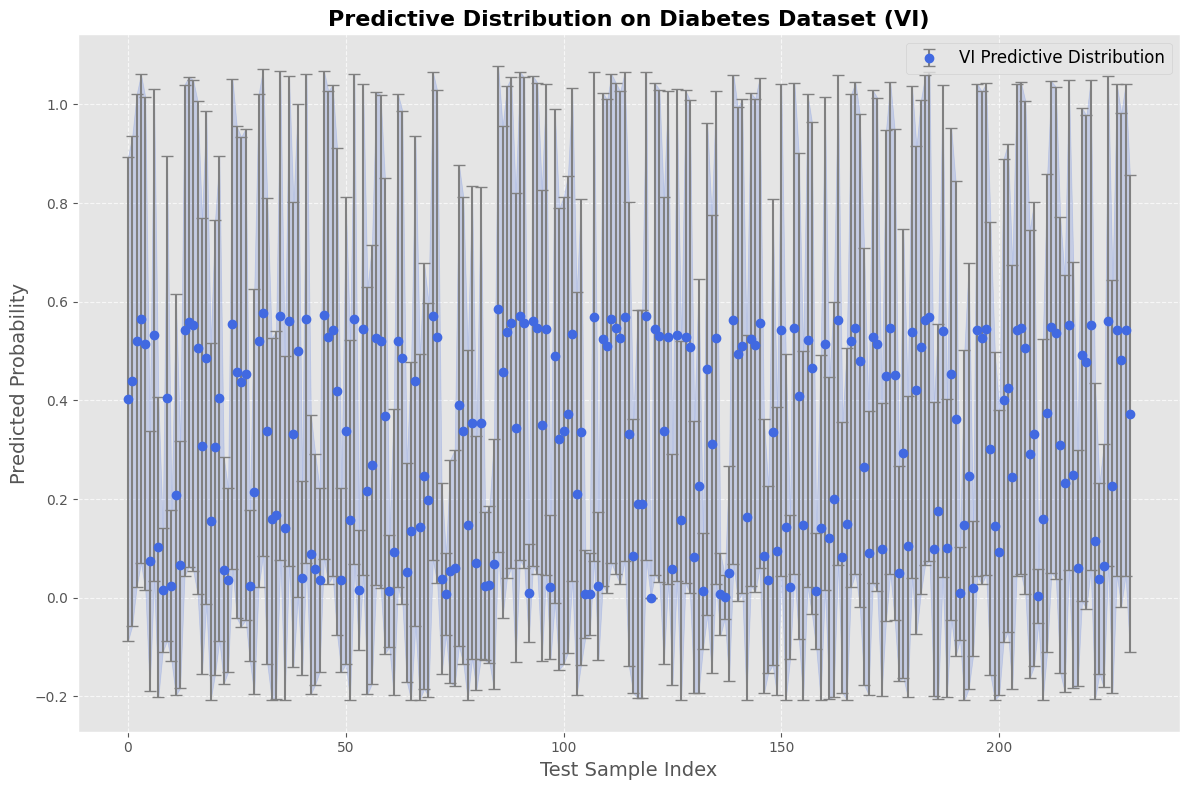

In [92]:
# Run main
if __name__ == "__main__":
    vi_model,x_test,y_test = main()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    vi_model.to(device)
    
    # Compute NLL for both models
    vi_nll = compute_nll_from_data(vi_model, x_test, y_test, device=device)
    
    # Compute ECE for both models
    vi_ece = compute_ece_from_data(vi_model, x_test, y_test, num_bins=15, device=device)
    
 
    print(f"VI NN - NLL: {vi_nll:.4f}, ECE: {vi_ece:.4f}")


   

  # Use a clean style (you can change this to your preferred style)
    plt.style.use('ggplot')

    # Generate predictive samples for the VI model on the test set
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    num_samples = 1000  # Increase for a smoother estimate
    pred_samples = vi_model.predict(x_test_tensor, num_samples=num_samples)  # shape: [num_samples, batch_size]

    # Compute mean and standard deviation over the samples
    pred_mean = pred_samples.float().mean(dim=0).detach().numpy()
    pred_std = pred_samples.float().std(dim=0).detach().numpy()

    # Define the x-axis: Test sample indices
    x_axis = np.arange(len(pred_mean))

    # Create the plot with improved aesthetics
    plt.figure(figsize=(12, 8))
    # Plot the mean with error bars
    plt.errorbar(x_axis, pred_mean, yerr=pred_std, fmt='o', 
                color='royalblue', ecolor='gray', capsize=4, label='VI Predictive Distribution')
    # Add shaded area for uncertainty
    plt.fill_between(x_axis, pred_mean - pred_std, pred_mean + pred_std, 
                    color='royalblue', alpha=0.2)

    # Set labels and title with enhanced styling
    plt.xlabel('Test Sample Index', fontsize=14)
    plt.ylabel('Predicted Probability', fontsize=14)
    plt.title('Predictive Distribution on Diabetes Dataset (VI)', fontsize=16, fontweight='bold')

    # Improve legend and grid appearance
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [93]:


def predict_with_uncertainty(X, T=100):
    """
    For each input in X, draw T samples from the variational posterior
    (using the guide) and compute the corresponding probabilities.
    Returns the mean prediction and variance (uncertainty) across samples.
    """
    predictive = pyro.infer.Predictive(bayesian_model.model,
                                       guide=bayesian_model.guide,
                                       num_samples=T,
                                       return_sites=("w", "b"))
    samples = predictive(X)
    # samples["w"]: shape (T, input_dim, 1), samples["b"]: shape (T,)
    predictions = []
    for i in range(T):
        w = samples["w"][i]
        b = samples["b"][i]
        logits = torch.matmul(X, w) + b
        probs = torch.sigmoid(logits).squeeze(1)  # shape (n_samples,)
        predictions.append(probs)
    predictions = torch.stack(predictions)  # shape (T, n_samples)
    mean_pred = predictions.mean(0)         # average prediction per sample
    variance_pred = predictions.var(0)      # uncertainty estimate per sample
    return mean_pred, variance_pred

# Example usage:
mean_predictions, prediction_uncertainty = predict_with_uncertainty(X, T=100)
print("Mean predictions:", mean_predictions)
print("Prediction uncertainty (variance):", prediction_uncertainty)


NameError: name 'X' is not defined